In [11]:
img_paths = {0: "ecoli Citrus\\2023-09-28_4_27_29_uv_Photo_Capture\\rotated\\rotated_0deg_Q4_2023-09-28_4_27_29_uv_Photo_Capture_4.png",
            1:"ecoli Citrus/2023-09-28_4_30_13_uv_Photo_Capture/processed_2023-09-28_4_30_13_uv_Photo_Capture_1.png",
            2: "ecoli Citrus/2023-09-28_3_19_42_uv_Photo_Capture/processed_2023-09-28_3_19_42_uv_Photo_Capture_1.png",
            3: "ecoli Citrus/2023-09-28_4_37_08_uv_Photo_Capture/processed_2023-09-28_4_37_08_uv_Photo_Capture_1.png",
            4: "ecoli Citrus/2023-09-28_4_41_43_uv_Photo_Capture/processed_2023-09-28_4_41_43_uv_Photo_Capture_1.png"}

(14, 16)


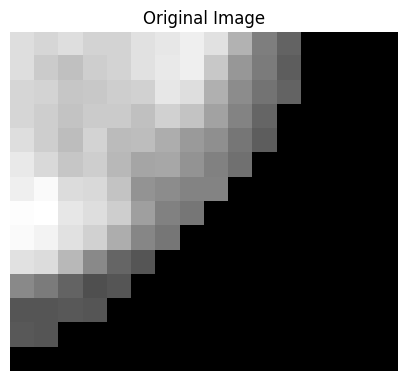

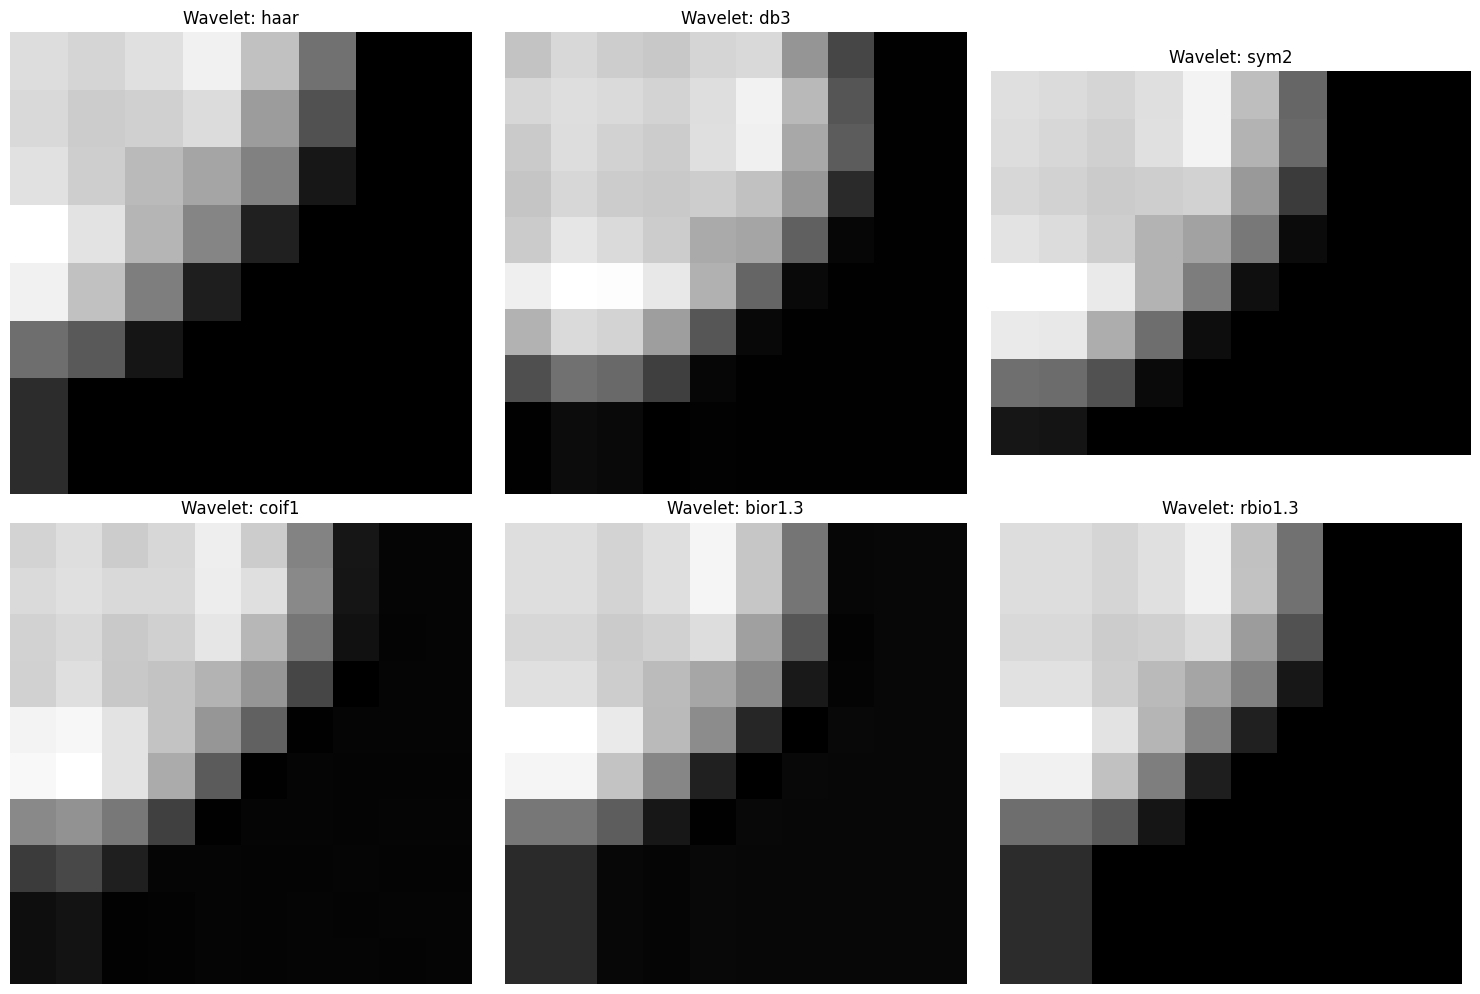

In [13]:
## Enhances an image using different wavelets by applying thresholding to wavelet **APPROXIMATE** coefficients and reconstructing the image. 

import pywt
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = img_paths[0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)
# List of wavelets to try
wavelets = ['haar', 'db3', 'sym2', 'coif1', 'bior1.3', 'rbio1.3']

# Dictionary to hold enhanced images
enhanced_images = {}

# Function to enhance image using specified wavelet
def enhance_image(img, wavelet_name):
    coeffs = pywt.wavedec2(img, wavelet_name, level=2)
    coeffs_H = list(map(lambda x: pywt.threshold(x, value=0.2, mode='hard'), coeffs[1]))
    return pywt.waverec2((coeffs[0], coeffs_H), wavelet_name)

# Enhance the image using different wavelets
for wavelet in wavelets:
    enhanced_images[wavelet] = enhance_image(img, wavelet)

# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Display the enhanced images using different wavelets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, (wavelet, enhanced_img) in zip(axes.flatten(), enhanced_images.items()):
    ax.imshow(enhanced_img, cmap='gray')
    ax.set_title(f"Wavelet: {wavelet}")
    ax.axis('off')
plt.tight_layout()
plt.show()


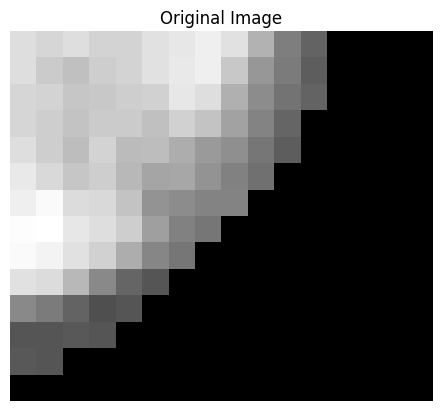

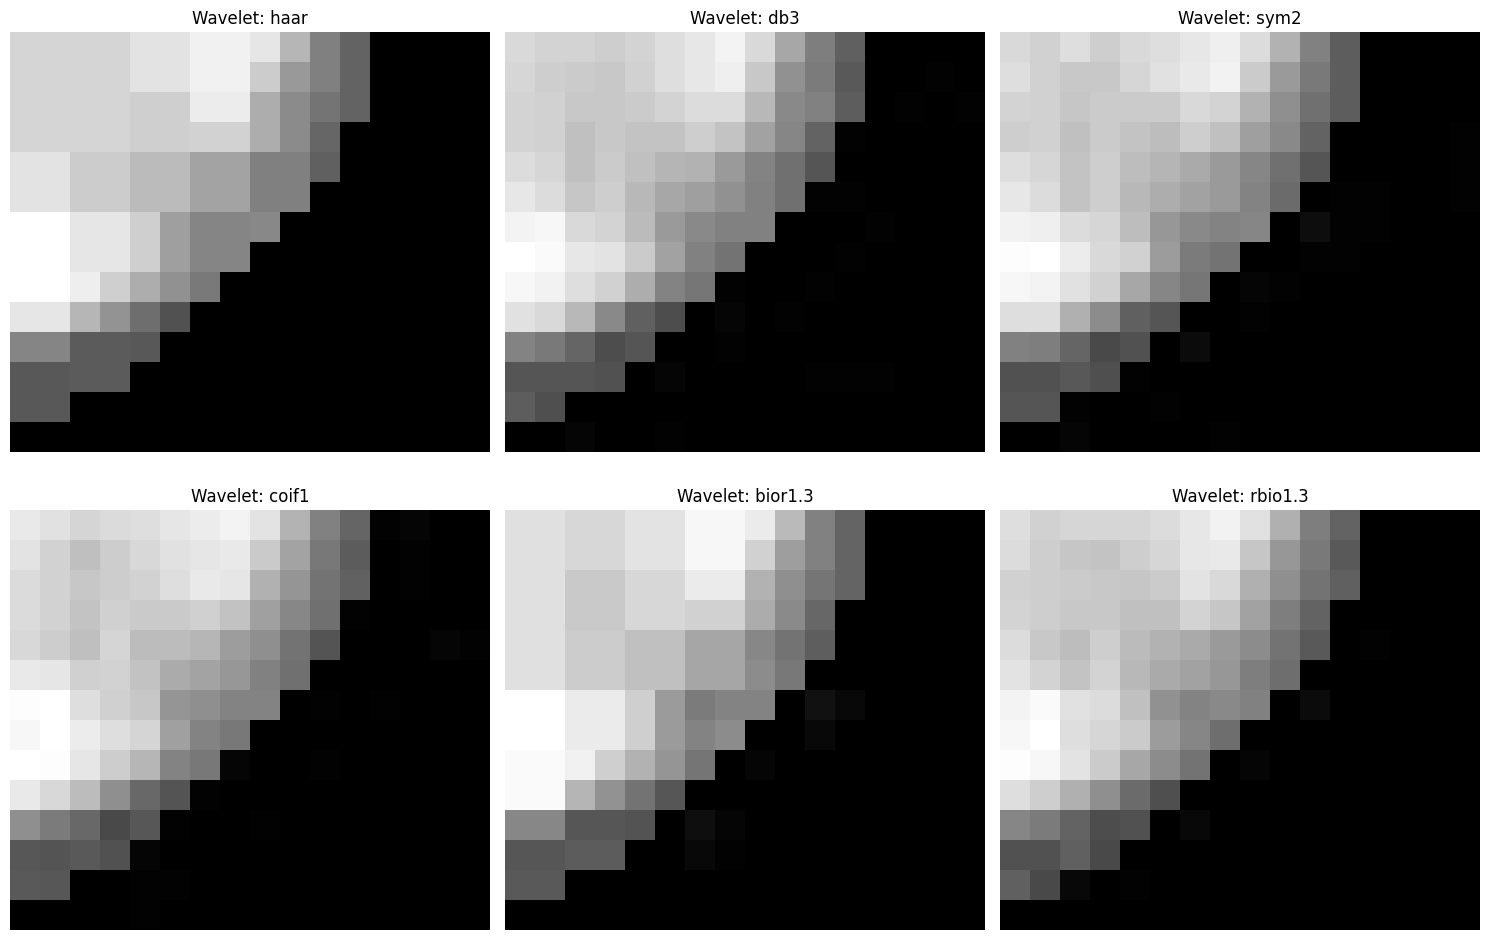

In [15]:
## Enhance an image using specified wavelets by performing multi-level wavelet decomposition, applying thresholding to **DETAIL** coefficients, 
## and reconstructing the image. 
import numpy as np
def enhance_image_with_wavelets(image_path, wavelet_name, mode='hard', value=None):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Perform a multi-level wavelet decomposition
    coeffs = pywt.wavedec2(img, wavelet_name, level=2)
    cA, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs

    # Set threshold value to a percentage of the maximum coefficient value if not provided
    if value is None:
        value = 0.1 * max([c.max() for c in (cH2, cV2, cD2, cH1, cV1, cD1)])

    # Apply thresholding to detail coefficients
    cH2 = pywt.threshold(cH2, value=value, mode=mode)
    cV2 = pywt.threshold(cV2, value=value, mode=mode)
    cD2 = pywt.threshold(cD2, value=value, mode=mode)
    cH1 = pywt.threshold(cH1, value=value, mode=mode)
    cV1 = pywt.threshold(cV1, value=value, mode=mode)
    cD1 = pywt.threshold(cD1, value=value, mode=mode)

    # Reconstruct the image from the modified coefficients
    coeffs = cA, (cH2, cV2, cD2), (cH1, cV1, cD1)
    enhanced_img = pywt.waverec2(coeffs, wavelet_name)

    # Ensure the enhanced image has the same scale as the original
    enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)

    return enhanced_img

# Load the image
img_path = img_paths[0]

# List of wavelets to try
wavelets = ['haar', 'db3', 'sym2', 'coif1', 'bior1.3', 'rbio1.3']

# Display the original image
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Enhance the image using different wavelets and display the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, wavelet in zip(axes.flatten(), wavelets):
    enhanced_img = enhance_image_with_wavelets(img_path, wavelet)
    ax.imshow(enhanced_img, cmap='gray')
    ax.set_title(f"Wavelet: {wavelet}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## Image Enhancement and Analysis

In [16]:
import os
import cv2
import pandas as pd
import numpy as np
import pywt

def calculate_psnr(original, enhanced):
    mse = np.mean((original - enhanced) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


In [17]:
def enhance_image_approx(img, wavelet_name, level):
    original_shape = img.shape
    coeffs = pywt.wavedec2(img, wavelet_name, level=level)
    # Zeroing out the detail coefficients for approximate enhancement
    coeffs = [coeffs[0]] + [(np.zeros_like(cH), np.zeros_like(cV), np.zeros_like(cD)) for cH, cV, cD in coeffs[1:]]
    enhanced_img = pywt.waverec2(coeffs, wavelet_name)
    enhanced_img = cv2.resize(enhanced_img, original_shape[::-1], interpolation=cv2.INTER_LINEAR)
    enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)
    return enhanced_img

def enhance_image_detail(img, wavelet_name, level, value=0.1):
    original_shape = img.shape
    coeffs = pywt.wavedec2(img, wavelet_name, level=level)
    # Applying thresholding to detail coefficients
    coeffs = [coeffs[0]] + [tuple(pywt.threshold(c, value=np.max(c) * value, mode='soft') for c in detail) for detail in coeffs[1:]]
    enhanced_img = pywt.waverec2(coeffs, wavelet_name)
    enhanced_img = cv2.resize(enhanced_img, original_shape[::-1], interpolation=cv2.INTER_LINEAR)
    enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)
    return enhanced_img

In [19]:
def process_images_and_calculate_psnr(base_dir, wavelets, output_csv='wavelet_psnr_results_v2.csv'):
    results_df = pd.DataFrame(columns=['File', 'Wavelet', 'Coefficient_Type', 'Level', 'PSNR'])

    for subdir, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')) and not file.startswith('processed_') \
            and not file.startswith('comparison_') and file.startswith('rotated_'):
                original_image_path = os.path.join(subdir, file)
                original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)

                for wavelet in wavelets:
                    max_level = pywt.dwt_max_level(min(original_img.shape), pywt.Wavelet(wavelet).dec_len)
                    for level in range(1, max_level + 1):
                        # Approximate coefficients enhancement
                        enhanced_img = enhance_image_approx(original_img, wavelet, level)
                        psnr = calculate_psnr(original_img, enhanced_img)
                        results_df = pd.concat([results_df, pd.DataFrame([{'File': file, 'Wavelet': wavelet, 'Coefficient_Type': 'Approximate', 'Level': level, 'PSNR': psnr}])], ignore_index=True)

                        # Detailed coefficients enhancement
                        enhanced_img = enhance_image_detail(original_img, wavelet, level)
                        psnr = calculate_psnr(original_img, enhanced_img)
                        results_df = pd.concat([results_df, pd.DataFrame([{'File': file, 'Wavelet': wavelet, 'Coefficient_Type': 'Detailed', 'Level': level, 'PSNR': psnr}])], ignore_index=True)

    # Save the results to a CSV file
    results_df.to_csv(output_csv, index=False)
    return results_df

# Specify your base directory and wavelets to use
base_dir = 'ecoli Citrus/'  # Update this path
wavelets = ['haar', 'db3', 'sym2', 'coif1', 'bior1.3', 'rbio1.3']

# Run the processing
# Make sure to execute this in your local environment as the code cannot be executed here directly.
results_df = process_images_and_calculate_psnr(base_dir, wavelets)
results_df.head()

C:\Users\vsneh\AppData\Local\Temp\ipykernel_21372\1233129387.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'File': file, 'Wavelet': wavelet, 'Coefficient_Type': 'Approximate', 'Level': level, 'PSNR': psnr}])], ignore_index=True)
C:\Users\vsneh\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
C:\Users\vsneh\AppData\Local\Temp\ipykernel_21372\2771886314.py:18: RuntimeWarning: invalid value encountered in cast
  enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)


,File,Wavelet,Coefficient_Type,Level,PSNR
0,rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Ca...,haar,Approximate,1,32.012243
1,rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Ca...,haar,Detailed,1,33.802446
2,rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Ca...,haar,Approximate,2,31.106139
3,rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Ca...,haar,Detailed,2,33.695566
4,rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Ca...,haar,Approximate,3,29.543678


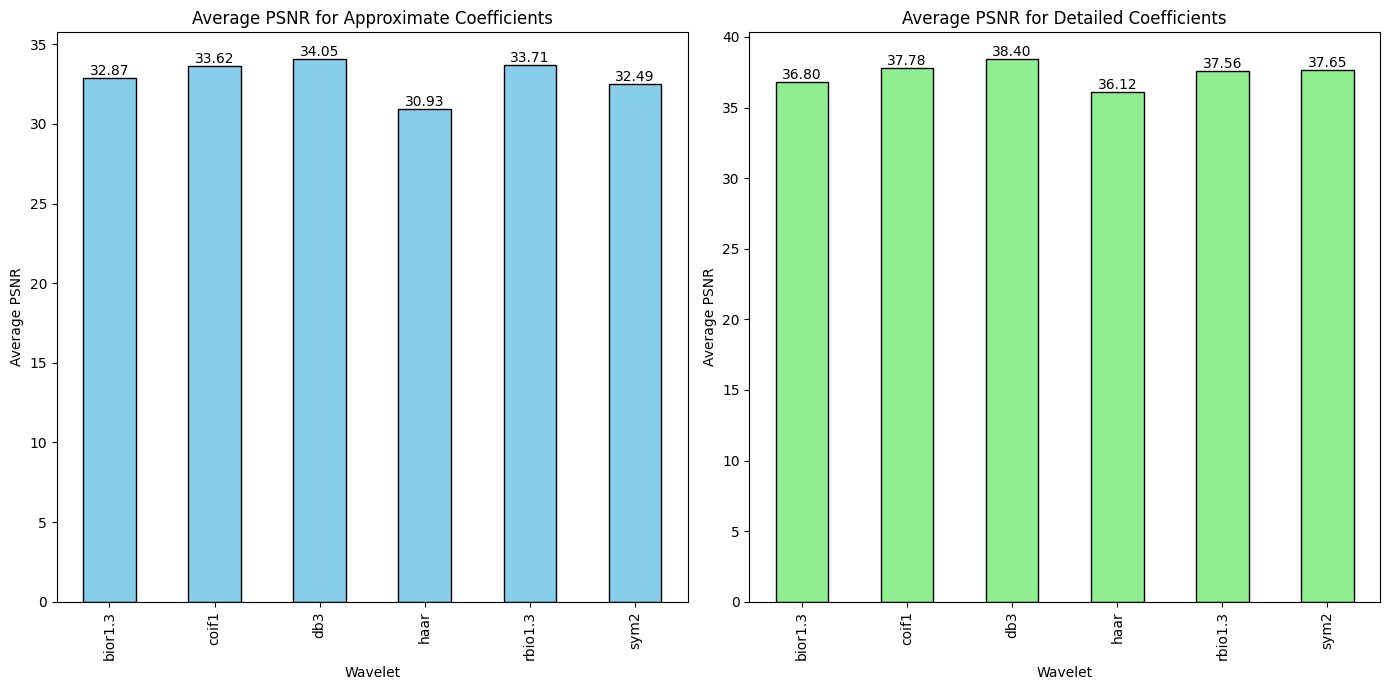

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

psnr_results_df = results_df
# Calculate the average PSNR for each wavelet and coefficient type
avg_psnr_approx = psnr_results_df[psnr_results_df['Coefficient_Type'] == 'Approximate'].groupby('Wavelet')['PSNR'].mean()
avg_psnr_detail = psnr_results_df[psnr_results_df['Coefficient_Type'] == 'Detailed'].groupby('Wavelet')['PSNR'].mean()

# Create bar graphs for the average PSNR values
plt.figure(figsize=(14, 7))

# Approximate coefficients
plt.subplot(1, 2, 1)
avg_psnr_approx.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average PSNR for Approximate Coefficients')
plt.ylabel('Average PSNR')
plt.xlabel('Wavelet')
# Add numbers on top of the bars
for i, value in enumerate(avg_psnr_approx):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Detailed coefficients
plt.subplot(1, 2, 2)
avg_psnr_detail.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average PSNR for Detailed Coefficients')
plt.ylabel('Average PSNR')
plt.xlabel('Wavelet')
# Add numbers on top of the bars
for i, value in enumerate(avg_psnr_detail):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Analysis

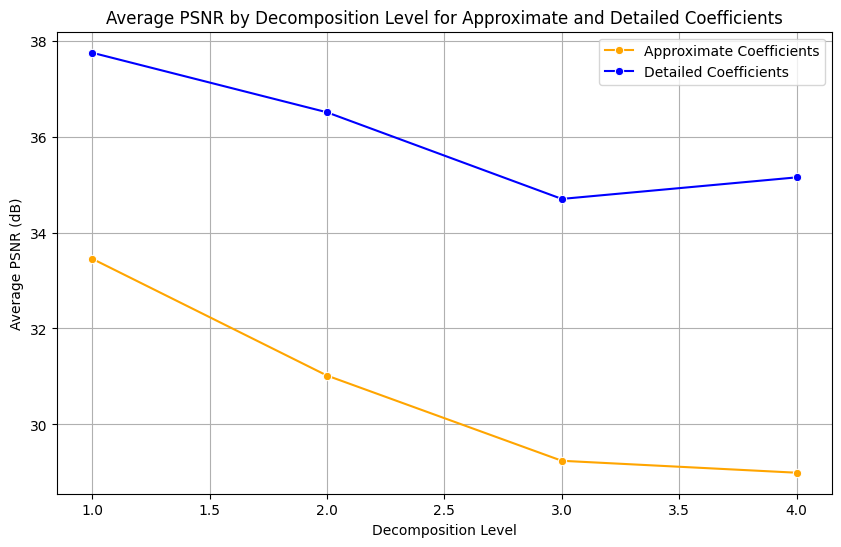

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file containing the PSNR results
results_path = 'wavelet_psnr_results_v2.csv'
results_df = pd.read_csv(results_path)

# Separate the data into two groups based on the coefficient type
approx_df = results_df[results_df['Coefficient_Type'] == 'Approximate']
detail_df = results_df[results_df['Coefficient_Type'] == 'Detailed']

# Calculate the average PSNR for each decomposition level for approximate and detailed coefficients
average_psnr_by_level_approx = approx_df.groupby('Level')['PSNR'].mean().reset_index()
average_psnr_by_level_detail = detail_df.groupby('Level')['PSNR'].mean().reset_index()

# Plotting the average PSNR by decomposition level for both coefficient types
plt.figure(figsize=(10, 6))

# Approximate coefficients
sns.lineplot(data=average_psnr_by_level_approx, x='Level', y='PSNR', marker='o', color='orange', label='Approximate Coefficients')

# Detailed coefficients
sns.lineplot(data=average_psnr_by_level_detail, x='Level', y='PSNR', marker='o', color='blue', label='Detailed Coefficients')

plt.title('Average PSNR by Decomposition Level for Approximate and Detailed Coefficients')
plt.xlabel('Decomposition Level')
plt.ylabel('Average PSNR (dB)')
plt.legend()
plt.grid(True)
plt.show()


Wavelet    bior1.3      coif1        db3       haar    rbio1.3       sym2
Level                                                                    
1        34.839675  35.698206  36.225732  35.258975  35.636167  35.944593
2              NaN        NaN        NaN  33.413012        NaN  34.135773
3              NaN        NaN        NaN  31.971754        NaN        NaN
4              NaN        NaN        NaN  32.072048        NaN        NaN


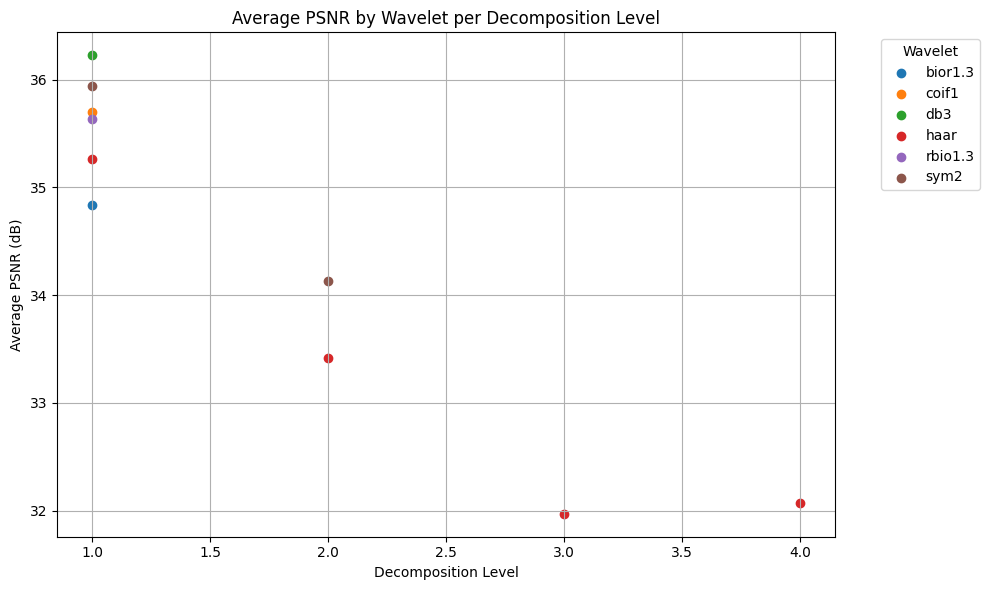

In [23]:
average_psnr_by_wavelet_level = results_df.groupby(['Level', 'Wavelet'])['PSNR'].mean().unstack()
print(average_psnr_by_wavelet_level)
# Plotting the average PSNR for each wavelet at each decomposition level
# Plotting the average PSNR for each wavelet at each decomposition level
plt.figure(figsize=(10, 6))

# We need to reshape the data to plot it as a scatter plot
for wavelet in average_psnr_by_wavelet_level.columns:
    plt.scatter(average_psnr_by_wavelet_level.index, average_psnr_by_wavelet_level[wavelet], label=wavelet)

plt.title('Average PSNR by Wavelet per Decomposition Level')
plt.xlabel('Decomposition Level')
plt.ylabel('Average PSNR (dB)')
plt.legend(title='Wavelet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
file_to_concentration = {
    "2023-09-28_3_19_42_uv_Photo_Capture": "10x8",
    "2023-09-28_4_27_29_uv_Photo_Capture": "10x0",
    "2023-09-28_4_30_13_uv_Photo_Capture": "10x5",
    "2023-09-28_4_33_18_uv_Photo_Capture": "10x6",
    "2023-09-28_4_37_08_uv_Photo_Capture": "10x6.7",
    "2023-09-28_4_39_21_uv_Photo_Capture": "10x7",
    "2023-09-28_4_41_43_uv_Photo_Capture": "10x7.4",
    "2023-09-28_4_44_31_uv_Photo_Capture": "10x7.7",
}


<Figure size 1400x800 with 0 Axes>

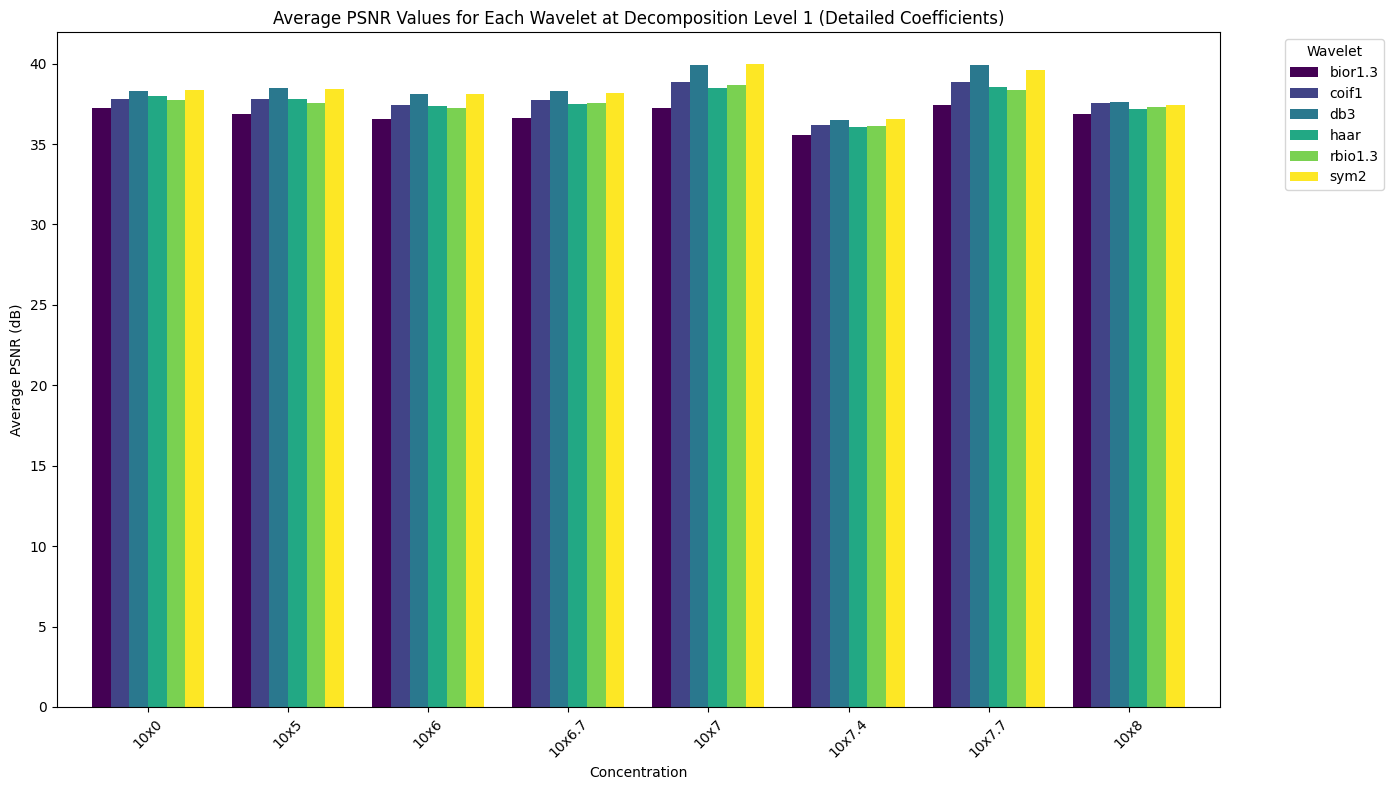

In [34]:
csv_file_path = 'wavelet_psnr_results_v2.csv'
psnr_results_df = pd.read_csv(csv_file_path)

psnr_results_df['Class'] = psnr_results_df['File'].str.extract(r'(\d{4}-\d{2}-\d{2}_\d{1,2}_\d{2}_\d{2}_uv_Photo_Capture)')

# Apply the updated mapping
psnr_results_df['Concentration'] = psnr_results_df['Class'].map(file_to_concentration)

detailed_df_corrected = psnr_results_df[
    (psnr_results_df['Coefficient_Type'] == 'Detailed') & 
    (psnr_results_df['Level'] == 1) & 
    (psnr_results_df['Concentration'].notna())
]

# Calculate the average PSNR for each wavelet within each concentration level
avg_psnr_per_wavelet_concentration = detailed_df_corrected.groupby(['Concentration', 'Wavelet'])['PSNR'].mean().unstack()

# Plotting the corrected information
plt.figure(figsize=(14, 8))
avg_psnr_per_wavelet_concentration.plot(kind='bar', figsize=(14, 8), width=0.8, colormap='viridis')
plt.title('Average PSNR Values for Each Wavelet at Decomposition Level 1 (Detailed Coefficients)')
plt.ylabel('Average PSNR (dB)')
plt.xlabel('Concentration')
plt.xticks(rotation=45)
plt.legend(title='Wavelet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [35]:
avg_psnr_per_wavelet_concentration

Wavelet,bior1.3,coif1,db3,haar,rbio1.3,sym2
Concentration,,,,,,
10x0,37.258391,37.794145,38.328906,37.978493,37.716510,38.341645
10x5,36.857986,37.830680,38.471746,37.795077,37.562857,38.433222
10x6,36.574572,37.428402,38.109856,37.352568,37.212248,38.081293
10x6.7,36.612732,37.760247,38.289024,37.517620,37.529083,38.164574
10x7,37.224634,38.846393,39.892729,38.458380,38.672637,39.948426
10x7.4,35.591452,36.170384,36.503989,36.036253,36.094349,36.546722
10x7.7,37.400497,38.861627,39.937207,38.538213,38.379085,39.591609
10x8,36.871645,37.525463,37.638918,37.182889,37.307242,37.401303


In [36]:
best_wavelet_per_class = avg_psnr_per_wavelet_concentration.idxmax(axis=1)
concentration_to_best_wavelet = {}

# Display the best wavelet for each class in text format
for class_name, wavelet in best_wavelet_per_class.items():
    concentration_to_best_wavelet[class_name] = wavelet
    print(f"Best wavelet for class '{class_name}': {wavelet}")

Best wavelet for class '10x0': sym2
Best wavelet for class '10x5': db3
Best wavelet for class '10x6': db3
Best wavelet for class '10x6.7': db3
Best wavelet for class '10x7': sym2
Best wavelet for class '10x7.4': sym2
Best wavelet for class '10x7.7': db3
Best wavelet for class '10x8': db3


In [37]:
file_to_concentration = {
    "2023-09-28_3_19_42_uv_Photo_Capture": "10x8",
    "2023-09-28_4_27_29_uv_Photo_Capture": "10x0",
    "2023-09-28_4_30_13_uv_Photo_Capture": "10x5",
    "2023-09-28_4_33_18_uv_Photo_Capture": "10x6",
    "2023-09-28_4_37_08_uv_Photo_Capture": "10x6.7",
    "2023-09-28_4_39_21_uv_Photo_Capture": "10x7",
    "2023-09-28_4_41_43_uv_Photo_Capture": "10x7.4",
    "2023-09-28_4_44_31_uv_Photo_Capture": "10x7.7",
}


In [38]:
file_to_best_wavelet = {file: concentration_to_best_wavelet[concentration] 
                        for file, concentration in file_to_concentration.items()}

file_to_best_wavelet

{'2023-09-28_3_19_42_uv_Photo_Capture': 'db3',
 '2023-09-28_4_27_29_uv_Photo_Capture': 'sym2',
 '2023-09-28_4_30_13_uv_Photo_Capture': 'db3',
 '2023-09-28_4_33_18_uv_Photo_Capture': 'db3',
 '2023-09-28_4_37_08_uv_Photo_Capture': 'db3',
 '2023-09-28_4_39_21_uv_Photo_Capture': 'sym2',
 '2023-09-28_4_41_43_uv_Photo_Capture': 'sym2',
 '2023-09-28_4_44_31_uv_Photo_Capture': 'db3'}

In [39]:
# Assuming psnr_results_df is your DataFrame with all PSNR results and mappings are defined as before

# First, add a 'Concentration' column to the DataFrame using the 'file_to_concentration' mapping
psnr_results_df['Concentration'] = psnr_results_df['Class'].map(file_to_concentration)

# Next, for simplicity, add a 'Best Wavelet' column to the DataFrame using the 'file_to_best_wavelet' mapping
psnr_results_df['Best Wavelet'] = psnr_results_df['Class'].map(file_to_best_wavelet)

# Now filter the DataFrame for rows where the Wavelet matches the 'Best Wavelet' for its class
best_psnr_df = psnr_results_df[psnr_results_df['Wavelet'] == psnr_results_df['Best Wavelet']]

# Group by 'Class' (or 'Concentration' if you prefer) and find the max PSNR value for each class
best_psnr_per_class = best_psnr_df.groupby(['Class', 'Concentration', 'Best Wavelet'])['PSNR'].max().reset_index()

# Display the results
print(best_psnr_per_class[['Class', 'Concentration', 'Best Wavelet', 'PSNR']])


                                 Class Concentration Best Wavelet       PSNR
0  2023-09-28_3_19_42_uv_Photo_Capture          10x8          db3  48.991010
1  2023-09-28_4_27_29_uv_Photo_Capture          10x0         sym2  48.985106
2  2023-09-28_4_30_13_uv_Photo_Capture          10x5          db3  48.931488
3  2023-09-28_4_33_18_uv_Photo_Capture          10x6          db3  47.790006
4  2023-09-28_4_37_08_uv_Photo_Capture        10x6.7          db3  47.619278
5  2023-09-28_4_39_21_uv_Photo_Capture          10x7         sym2  48.130804
6  2023-09-28_4_41_43_uv_Photo_Capture        10x7.4         sym2  47.087884
7  2023-09-28_4_44_31_uv_Photo_Capture        10x7.7          db3  49.094368


In [40]:
file_to_best_wavelet

{'2023-09-28_3_19_42_uv_Photo_Capture': 'db3',
 '2023-09-28_4_27_29_uv_Photo_Capture': 'sym2',
 '2023-09-28_4_30_13_uv_Photo_Capture': 'db3',
 '2023-09-28_4_33_18_uv_Photo_Capture': 'db3',
 '2023-09-28_4_37_08_uv_Photo_Capture': 'db3',
 '2023-09-28_4_39_21_uv_Photo_Capture': 'sym2',
 '2023-09-28_4_41_43_uv_Photo_Capture': 'sym2',
 '2023-09-28_4_44_31_uv_Photo_Capture': 'db3'}

### Image Reconstrcution using IDWT

In [42]:
import os
import cv2
import numpy as np
import pywt

# Assume file_to_concentration and best_wavelets dictionaries are defined as before

base_dir = "ecoli Citrus"
for class_name, concentration in file_to_concentration.items():
    class_dir = os.path.join(base_dir, class_name)
    augments_dir = os.path.join(class_dir, "augments")
    os.makedirs(augments_dir, exist_ok=True)  # Ensure the augments directory exists

    # Get all processed images for the class
    rotated_images = [img for img in os.listdir(os.path.join(class_dir, 'rotated')) if img.startswith('rotated_')]
    for idx, img_name in enumerate(rotated_images):
        img_path = os.path.join(class_dir, 'rotated', img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Determine the best wavelet for the current class
        wavelet_name = file_to_best_wavelet[class_name]

        # Enhance the image using detailed coefficients and IDWT
        enhanced_img = enhance_image_detail(image, wavelet_name, level=1, value=0.1)

        # Save the enhanced image with the new naming convention
        new_img_name = f"recomposed_{concentration.replace('^', '')}_{idx+1}.jpg"
        # print(os.path.join(augments_dir, new_img_name))
        cv2.imwrite(os.path.join(augments_dir, new_img_name), enhanced_img)
    print(f"Saved Images to ..{class_name}/augments")


Saved Images to ..2023-09-28_3_19_42_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_27_29_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_30_13_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_33_18_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_37_08_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_39_21_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_41_43_uv_Photo_Capture/augments
Saved Images to ..2023-09-28_4_44_31_uv_Photo_Capture/augments


### Data Augmentation

In [43]:
import os
import shutil
import Augmentor

# Base directory where the class directories are located
base_dir = "ecoli Citrus"
total_images_needed_per_class = 250  # Target number of images per class

# Final directory to move all augmented images
final_augments_dir = os.path.join(base_dir, "Final_Augmented_Images")
os.makedirs(final_augments_dir, exist_ok=True)

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    augments_dir = os.path.join(class_dir, "augments")
    concentration = file_to_concentration.get(class_name, "")

    if os.path.isdir(augments_dir):
        # Initialize the Augmentor pipeline
        p = Augmentor.Pipeline(augments_dir, output_directory="output")
        
        # Define the augmentations
        p.flip_left_right(probability=0.4)
        p.flip_top_bottom(probability=0.6)
        p.rotate(probability=0.8, max_left_rotation=11, max_right_rotation=12)

        # Directly sample the target number of images
        p.sample(total_images_needed_per_class)

        # After augmentation, rename the 'output' folder
        output_dir = os.path.join(augments_dir, "output")
        new_output_dir = os.path.join(augments_dir, f"augments_{concentration}")
        if os.path.exists(output_dir):
            os.rename(output_dir, new_output_dir)

        # Move the newly named output directory to the final directory
        final_class_augment_dir = os.path.join(final_augments_dir, f"Augments_{concentration}")
        if os.path.exists(final_class_augment_dir):
            shutil.rmtree(final_class_augment_dir)  
        shutil.move(new_output_dir, final_class_augment_dir)
        
        print(final_class_augment_dir)


Initialised with 62 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=16x16 at 0x20235A6B160>: 100%|██| 250/250 [00:01<00:00, 170.49 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x8
Initialised with 64 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_27_29_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=15x14 at 0x20233D712D0>: 100%|██| 250/250 [00:01<00:00, 183.26 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x0
Initialised with 64 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_30_13_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=14x14 at 0x2023589E5F0>: 100%|██| 250/250 [00:01<00:00, 196.27 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x5
Initialised with 64 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_33_18_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=13x14 at 0x20235EE3DF0>: 100%|██| 250/250 [00:01<00:00, 154.18 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x6
Initialised with 48 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_37_08_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=12x13 at 0x202357E2E90>: 100%|██| 250/250 [00:01<00:00, 190.02 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x6.7
Initialised with 64 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_39_21_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=12x13 at 0x20235A6A170>: 100%|██| 250/250 [00:01<00:00, 181.97 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x7
Initialised with 64 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_41_43_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=13x11 at 0x2023589ECE0>: 100%|██| 250/250 [00:01<00:00, 186.65 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x7.4
Initialised with 64 image(s) found.
Output directory set to ecoli Citrus\2023-09-28_4_44_31_uv_Photo_Capture\augments\output.

Processing <PIL.Image.Image image mode=L size=14x13 at 0x20233D73AF0>: 100%|██| 250/250 [00:01<00:00, 184.77 Samples/s]


ecoli Citrus\Final_Augmented_Images\Augments_10x7.7


### Cleaning Empty Directories and Stuff

In [44]:
import os
import shutil

base_dir = "ecoli Citrus"

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    # Ensure that we only look into directories
    if os.path.isdir(class_dir):
        augments_dir = os.path.join(class_dir, "augments")
        
        # Check if the 'augments' directory exists and remove it
        if os.path.isdir(augments_dir):
            shutil.rmtree(augments_dir)
            print(f"Removed: {augments_dir}")


Removed: ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_27_29_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_30_13_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_33_18_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_37_08_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_39_21_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_41_43_uv_Photo_Capture\augments
Removed: ecoli Citrus\2023-09-28_4_44_31_uv_Photo_Capture\augments


### Enlarge for YoloV8

In [45]:
import cv2
import numpy as np
import os

def upscale_and_pad_image(image_path, target_size=(640, 640)):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    scale = min(target_size[0] / height, target_size[1] / width)
    new_width = int(width * scale)
    new_height = int(height * scale)
    upscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    delta_w = target_size[1] - new_width
    delta_h = target_size[0] - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]
    padded_image = cv2.copyMakeBorder(upscaled_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return padded_image

def process_augmented_images(base_dir, target_dir):
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        enlarged_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(enlarged_class_dir, exist_ok=True)
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            padded_image = upscale_and_pad_image(img_path)
            
            # Save the enlarged image to the new directory
            save_path = os.path.join(enlarged_class_dir, img_name)
            cv2.imwrite(save_path, padded_image)

# Define your base and target directories
base_dir = "ecoli Citrus/Final_Augmented_Images"
target_dir = "ecoli Citrus/Enlarged"

# Process all augmented images
process_augmented_images(base_dir, target_dir)


## Rough

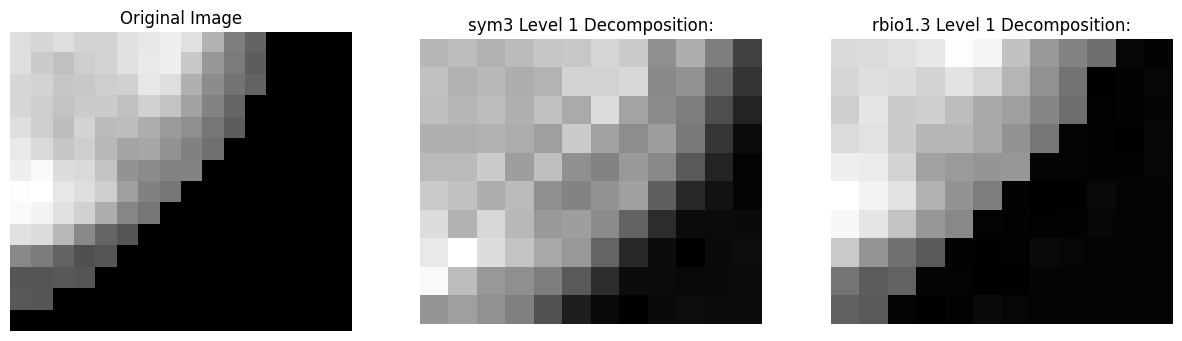

In [35]:
import pywt
import cv2
import matplotlib.pyplot as plt

def display_recomposed_images(image_path, wavelet_name, wv1, lv1, wv2, lv2):
    # Load the original image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Perform 1 level decomposition and reconstruction
    coeffs_1 = pywt.wavedec2(img, wv1, level=lv1)
    recomposed_1 = pywt.waverec2(coeffs_1, wavelet_name)
    
    # Perform 2 level decomposition and reconstruction
    coeffs_2 = pywt.wavedec2(img, wv2, level=lv2)
    recomposed_2 = pywt.waverec2(coeffs_2, wavelet_name)
    
    # Plotting original, 1 level, and 2 level decomposed images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(recomposed_1, cmap='gray')
    axs[1].set_title(f'{wv1} Level {lv1} Decomposition:')
    axs[1].axis('off')
    
    axs[2].imshow(recomposed_2, cmap='gray')
    axs[2].set_title(f'{wv2} Level {lv2} Decomposition:')
    axs[2].axis('off')
    
    plt.show()

# Example usage
image_path = img_paths[0]  # Update this path to your actual image file
best_wavelet = 'rbio1.5'  # Replace with the best-performing wavelet name
display_recomposed_images(image_path, best_wavelet, 'sym3', 1, 'rbio1.3', 1)


In [27]:
# Let's list all available wavelets in PyWavelets for the specified families: 'haar', 'db', 'sym', 'coif', 'bior', 'rbio'
import pywt

wavelet_families = ['haar', 'db', 'sym', 'coif', 'bior', 'rbio']

# Initialize an empty dictionary to store the available wavelets for each family
available_wavelets = {}

# Loop through each family and get the list of available wavelets
for family in wavelet_families:
    available_wavelets[family] = pywt.wavelist(family)

# Now, let's display the available wavelets for each requested family
for family, wavelets in available_wavelets.items():
    print(f"Available Wavelets in '{family}' Family:")
    for wavelet in wavelets:
        print(wavelet)
    print("\n")  # Add a new line for better readability between families


Available Wavelets in 'haar' Family:
haar


Available Wavelets in 'db' Family:
db1
db2
db3
db4
db5
db6
db7
db8
db9
db10
db11
db12
db13
db14
db15
db16
db17
db18
db19
db20
db21
db22
db23
db24
db25
db26
db27
db28
db29
db30
db31
db32
db33
db34
db35
db36
db37
db38


Available Wavelets in 'sym' Family:
sym2
sym3
sym4
sym5
sym6
sym7
sym8
sym9
sym10
sym11
sym12
sym13
sym14
sym15
sym16
sym17
sym18
sym19
sym20


Available Wavelets in 'coif' Family:
coif1
coif2
coif3
coif4
coif5
coif6
coif7
coif8
coif9
coif10
coif11
coif12
coif13
coif14
coif15
coif16
coif17


Available Wavelets in 'bior' Family:
bior1.1
bior1.3
bior1.5
bior2.2
bior2.4
bior2.6
bior2.8
bior3.1
bior3.3
bior3.5
bior3.7
bior3.9
bior4.4
bior5.5
bior6.8


Available Wavelets in 'rbio' Family:
rbio1.1
rbio1.3
rbio1.5
rbio2.2
rbio2.4
rbio2.6
rbio2.8
rbio3.1
rbio3.3
rbio3.5
rbio3.7
rbio3.9
rbio4.4
rbio5.5
rbio6.8


